In [7]:
# import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
import seaborn as sns
import os
import glob
import re
import random
import bisect
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [8]:
# Load the datasets of origins
folder_path = "Origins"
file_paths = glob.glob(os.path.join(folder_path, "*.csv"))
origins = []
for file_path in file_paths:
    # Load CSV file using pandas (for renaming columns)
    df = pd.read_csv(file_path)
    df['started_at'] = pd.to_datetime(df['started_at'], format = 'ISO8601')
    df['ended_at'] = pd.to_datetime(df['ended_at'], format = 'ISO8601')
    df.head(10)
    origins.append(df)
origins.sort(key=lambda d: np.unique(d['start_station_name']))
print(f'{len(origins)} origin stations')

# Load the datasets of destinations
folder_path = "Destinations"
file_paths = glob.glob(os.path.join(folder_path, "*.csv"))
destinations = []
for file_path in file_paths:
    # Load CSV file using pandas (for renaming columns)
    df = pd.read_csv(file_path)
    df.head(10)
    df['started_at'] = pd.to_datetime(df['started_at'], format = 'ISO8601')
    df['ended_at'] = pd.to_datetime(df['ended_at'], format = 'ISO8601')
    destinations.append(df)
    
destinations.sort(key=lambda d: np.unique(d['end_station_name']))
print(f'{len(destinations)} destination stations')

# Load the dataframe of stations
stations = pd.read_csv('current_bluebikes_stations.csv')
stations = stations.sort_values('NAME')
stations = stations.reset_index(drop=True)
stations['Total Docks'] = (stations['Total Docks'].fillna(0)).astype(int)
stations['Seasonal Status'] = stations['Seasonal Status'].fillna('Unavailable')
print(f'{len(stations)} stations reported in blue-bike dataset')

# Detect and remove the uncoming stations that do not have enough/any trips
upcoming = []
for i in range(len(origins)):
    if stations['Number'][i] == "TBD - upcoming install":
        upcoming.append(i)
print('Upcoming stations:')
for u in upcoming:
    print(stations.NAME[u])

stations.drop(upcoming, inplace=True)
stations = stations.reset_index(drop=True)
origins = [i for j, i in enumerate(origins) if j not in upcoming]
destinations = [i for j, i in enumerate(destinations) if j not in upcoming]



/tmp/ipykernel_18648/898789907.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  origins.sort(key=lambda d: np.unique(d['start_station_name']))


491 origin stations
491 destination stations
491 stations reported in blue-bike dataset
Upcoming stations:
1515 Commonwealth Ave
99 Coolidge Ave
Arsenal on the Charles
Damrell St at Old Colony Ave
Melnea Cass Blvd at Hampden St
West Street


/tmp/ipykernel_18648/898789907.py:27: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  destinations.sort(key=lambda d: np.unique(d['end_station_name']))


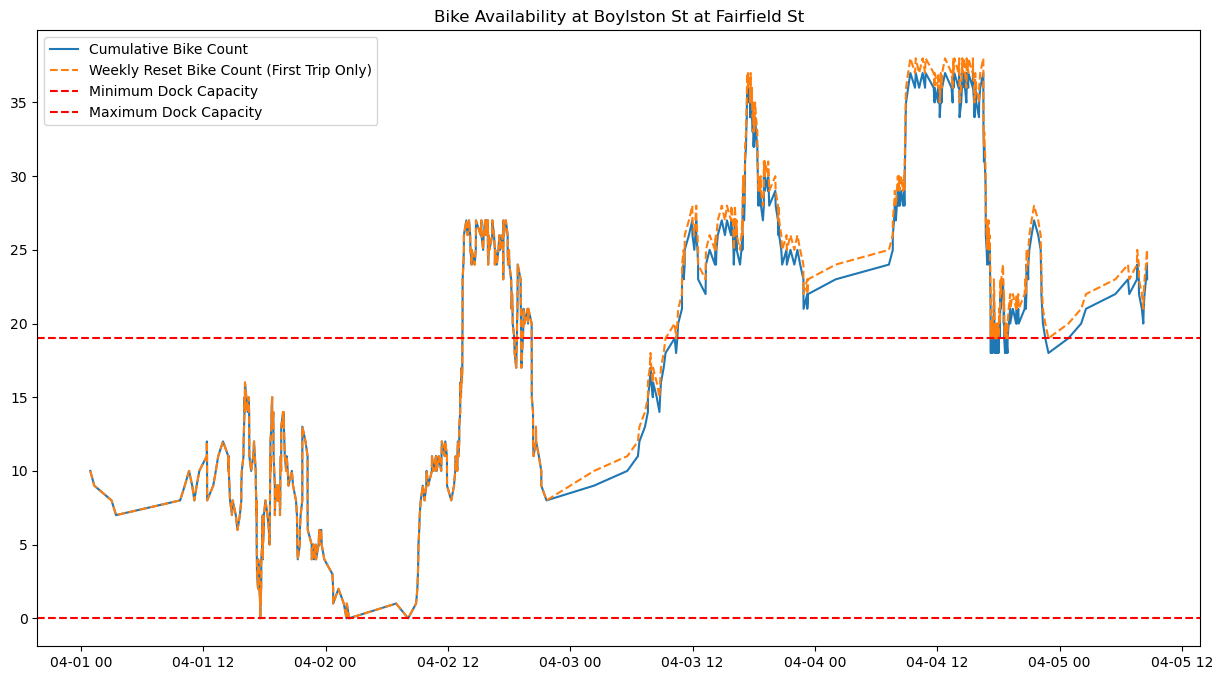

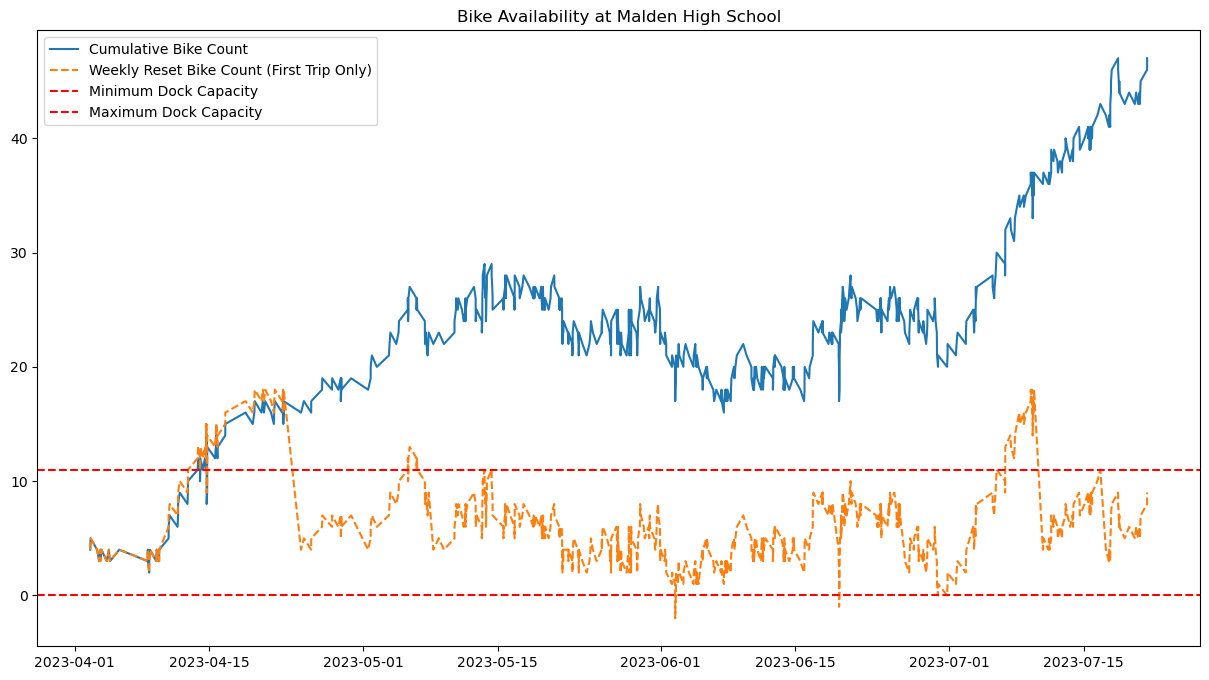

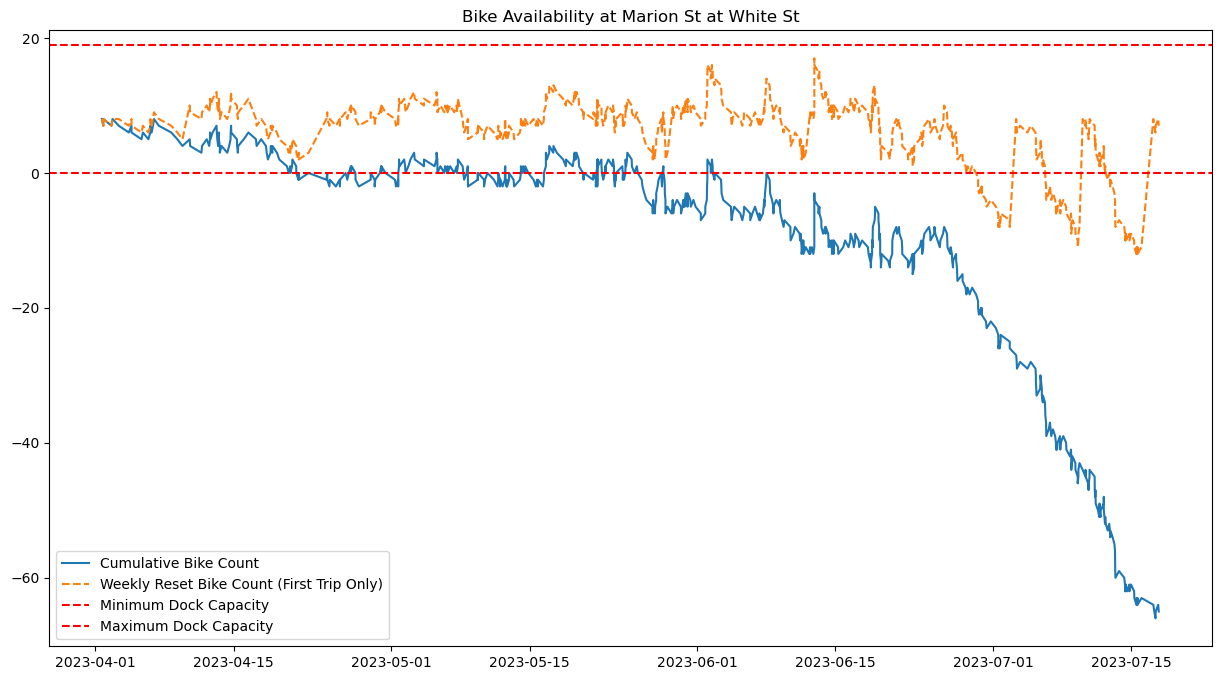

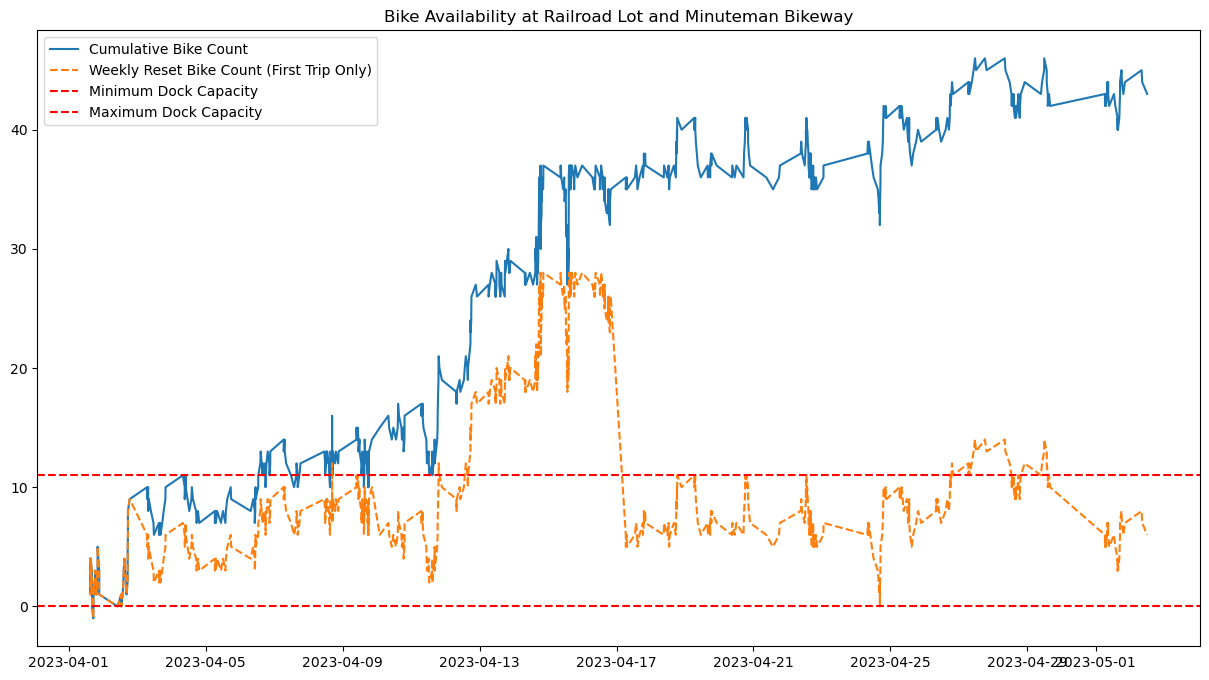

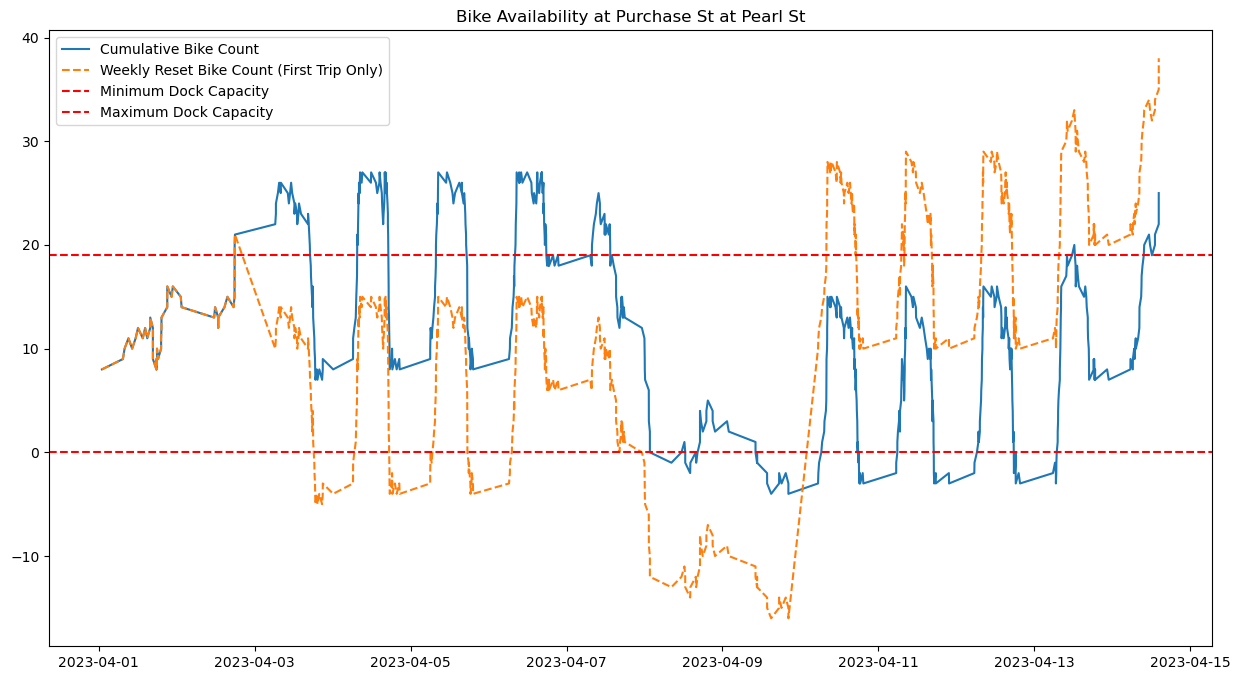

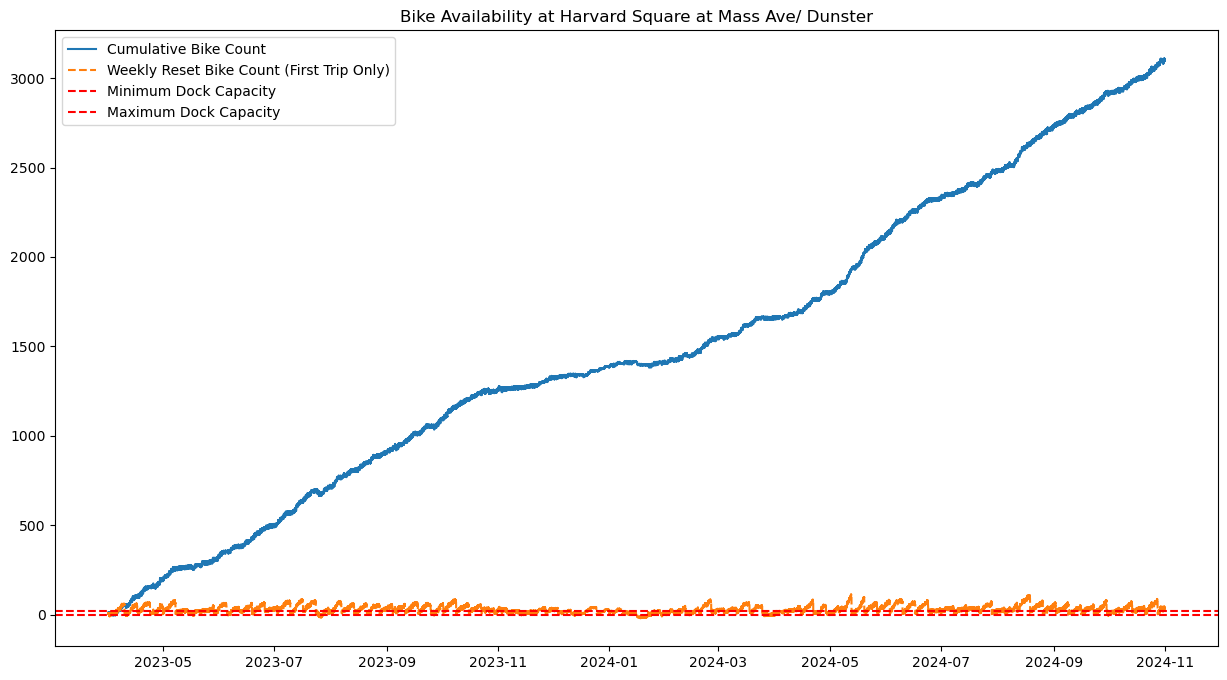

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,end_lat,end_lng,member_casual,start_distance,end_distance,time,bikechange,num_bikes,weekday,num_bikes_weekly
0,280522,C3E61F51765EC1BF,docked_bike,2023-04-01 00:14:10.000,2023-04-01 00:20:19.000,Beacon St at Washington / Kirkland,S32003,Harvard Square at Mass Ave/ Dunster,M32018,42.378754,...,42.373268,-71.118579,casual,5.412947e-07,0.000000e+00,2023-04-01 00:20:19.000,1,10,5,6
1,280301,3BC255EB1E131D87,docked_bike,2023-04-01 00:10:15.000,2023-04-01 00:36:09.000,Tremont St at Hamilton Pl,B32056,Harvard Square at Mass Ave/ Dunster,M32018,42.356683,...,42.373268,-71.118579,casual,5.780138e-07,0.000000e+00,2023-04-01 00:36:09.000,1,11,5,7
2,280348,4C8D1484E18AFA67,docked_bike,2023-04-01 00:06:15.000,2023-04-01 00:36:18.000,Tremont St at Hamilton Pl,B32056,Harvard Square at Mass Ave/ Dunster,M32018,42.356683,...,42.373268,-71.118579,casual,5.780138e-07,0.000000e+00,2023-04-01 00:36:18.000,1,12,5,8
3,209450,E38DD9BFA1F006FA,docked_bike,2023-04-01 00:56:39.000,2023-04-01 01:04:17.000,Harvard Square at Mass Ave/ Dunster,M32018,Graham and Parks School – Linnaean St at Walke...,M32068,42.373268,...,42.382944,-71.124498,member,0.000000e+00,4.313931e-07,2023-04-01 00:56:39.000,-1,11,5,7
4,292997,B73940BD8E2FA1B2,docked_bike,2023-04-01 01:01:52.000,2023-04-01 01:09:11.000,Harvard Square at Mass Ave/ Dunster,M32018,191 Beacon St,S32035,42.373268,...,42.380323,-71.108786,member,0.000000e+00,3.733631e-07,2023-04-01 01:01:52.000,-1,10,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208967,273942,EC19F68F52B605AA,electric_bike,2024-10-31 22:06:30.044,2024-10-31 23:28:08.951,Harvard University River Houses at DeWolfe St ...,M32038,Harvard Square at Mass Ave/ Dunster,M32018,42.369154,...,42.373268,-71.118579,casual,2.255139e-04,0.000000e+00,2024-10-31 23:28:08.951,1,3097,3,33
208968,278910,4ACD7B8B2BD0C19B,electric_bike,2024-10-31 23:33:02.968,2024-10-31 23:39:04.680,Harvard Square at Mass Ave/ Dunster,M32018,Harvard Square at Mass Ave/ Dunster,M32018,42.373268,...,42.373268,-71.118579,casual,0.000000e+00,0.000000e+00,2024-10-31 23:33:02.968,-1,3096,3,32
208969,278910,4ACD7B8B2BD0C19B,electric_bike,2024-10-31 23:33:02.968,2024-10-31 23:39:04.680,Harvard Square at Mass Ave/ Dunster,M32018,Harvard Square at Mass Ave/ Dunster,M32018,42.373268,...,42.373268,-71.118579,casual,0.000000e+00,0.000000e+00,2024-10-31 23:39:04.680,1,3097,3,33
208970,278935,5337782B29F5C3DF,electric_bike,2024-10-31 23:39:54.945,2024-10-31 23:45:41.634,Harvard Square at Mass Ave/ Dunster,M32018,Harvard Square at Mass Ave/ Dunster,M32018,42.373268,...,42.373268,-71.118579,casual,0.000000e+00,0.000000e+00,2024-10-31 23:39:54.945,-1,3096,3,32


In [9]:
# Define a function to plot cumulative activities of a station with and without weekly rebalancing

def station_activity_with_reset(n, start=0, end=-1, plotting=True, reset_value=None):
    origin = origins[n]
    destination = destinations[n]
    name = stations.NAME[n]

    # Process start and end station matches
    start_match = origin[origin['start_station_name'] == name].copy()
    start_match['time'] = start_match['started_at']
    start_match['bikechange'] = -1

    end_match = destination[destination['end_station_name'] == name].copy()
    end_match['time'] = end_match['ended_at']
    end_match['bikechange'] = +1

    # Combine and sort
    combined = pd.concat([start_match, end_match], ignore_index=True)
    combined = combined.sort_values('time').reset_index(drop=True)[start:end]
    combined['num_bikes'] = np.cumsum(combined['bikechange']) + stations['Total Docks'][n] // 2

    # Add weekday column
    combined['weekday'] = combined['time'].dt.weekday  # Get the day of the week (0=Monday, ..., 6=Sunday)

    # Reset the bike count only for the first trip on each Monday
    num_bikes_weekly = []
    if reset_value == None:
        reset_value = stations['Total Docks'][n] // 2  # Reset to half the total docks
    current_bike_count = reset_value
    last_weekday = None  # To track when Monday starts for the first trip

    for i, row in combined.iterrows():
        if row['weekday'] == 0 and row['weekday'] != last_weekday:  # First trip on Monday
            current_bike_count = reset_value
        current_bike_count += row['bikechange']
        num_bikes_weekly.append(current_bike_count)
        last_weekday = row['weekday']  # Update the last seen weekday

    combined['num_bikes_weekly'] = num_bikes_weekly

    # Plot if required
    if plotting:
        fig, ax = plt.subplots(figsize=(15, 8))
        plt.plot(combined['time'].values, combined['num_bikes'].values, label='Cumulative Bike Count')
        plt.plot(combined['time'].values, combined['num_bikes_weekly'].values, label='Weekly Reset Bike Count (First Trip Only)', linestyle='--')
        ax.axhline(y=0, color='red', linestyle='--', label='Minimum Dock Capacity')
        ax.axhline(y=stations['Total Docks'][n], color='red', linestyle='--', label='Maximum Dock Capacity')
        plt.title(f'Bike Availability at {name}')
        plt.legend()
        plt.show()

    return combined

# Test the function on random samples and a specific station
for i in random.sample(range(0, len(origins)), 5):
    station_activity_with_reset(i, start=0, end=700)

station_activity_with_reset(228, 0, -1, reset_value = 5)


In [10]:
# Define a function that only keeps the weekdays
def weekdays(n):
    data = station_activity_with_reset(n, plotting=False)
    data = data[data.weekday.isin(range(5))]
    data = data.reset_index(drop=True)
    return data

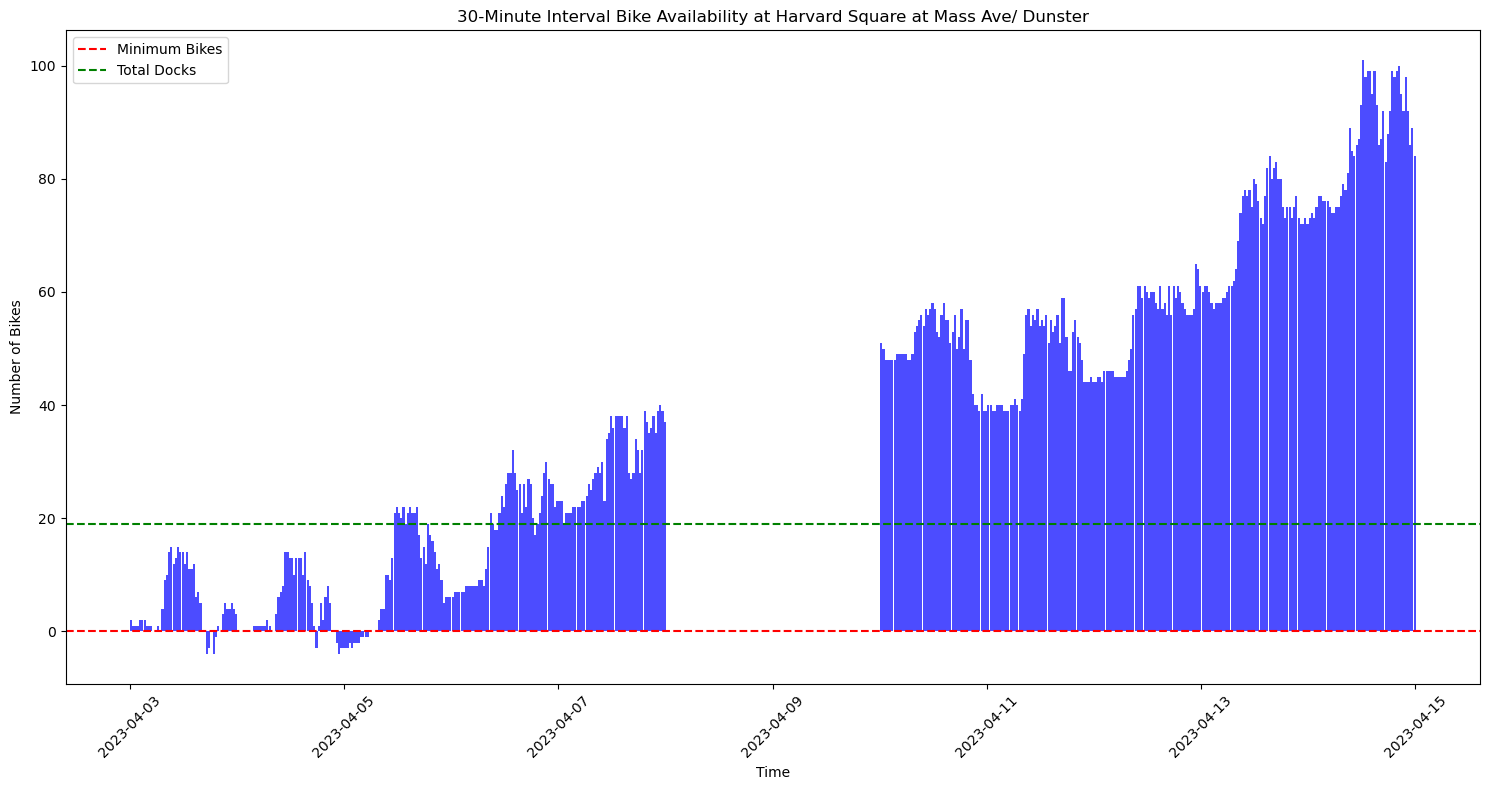

-4 101


In [11]:
# Define a function to report the bike availability in time intervals of e.g. 30 mins

def datetime_range(start, end, delta=dt.timedelta(minutes=30)):
    current = start
    while current <= end:  # Include the end time as well
        yield current
        current += delta

def find_closest(arr, target):
    idx = bisect.bisect_left(arr, target)

    # Adjust for bounds
    if idx == 0:
        return 0
    if idx == len(arr):
        return idx - 1

    # Find the closest value
    return idx if abs(arr[idx] - target) < abs(arr[idx - 1] - target) else idx - 1

def bikes_intervals(n, pstart=0, pend=500, reset_weekly = True, interval = 30):
    # Generate station activity data
    data = station_activity_with_reset(n, pstart, pend, plotting=False)
    
    # Ensure time is sorted for bisect
    data = data.sort_values('time').reset_index(drop=True)
    
    # Set up the 30-minute intervals
    start = data['time'].min()
    end = data['time'].max()
    intervals = list(datetime_range(start, end, ))
    
    # Map time intervals to bike counts
    bikes = []
    for T in intervals:
        idx = find_closest(data['time'], T)
        if reset_weekly:
            bikes.append(data.loc[idx, 'num_bikes_weekly'])
        else:
            bikes.append(data.loc[idx, 'num_bikes'])
    
    # Create the DataFrame
    df = pd.DataFrame({
        'time': intervals,
        'bikes': bikes
    })
    # remove weekends
    df = df[df.time.dt.weekday.isin(range(5))]
    df = df.reset_index(drop=True)

    # Plot the bar chart
    plt.figure(figsize=(15, 8))
    plt.bar(df['time'], df['bikes'], width=0.02, color='blue', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', label='Minimum Bikes')
    plt.axhline(y=stations['Total Docks'][n], color='green', linestyle='--', label='Total Docks')
    plt.xlabel('Time')
    plt.ylabel('Number of Bikes')
    plt.title(f'30-Minute Interval Bike Availability at {stations.NAME[n]}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

    return df

# Example usage
data = bikes_intervals(228, pstart=0, pend=5000, reset_weekly=False)
print(np.min(data.bikes), np.max(data.bikes))

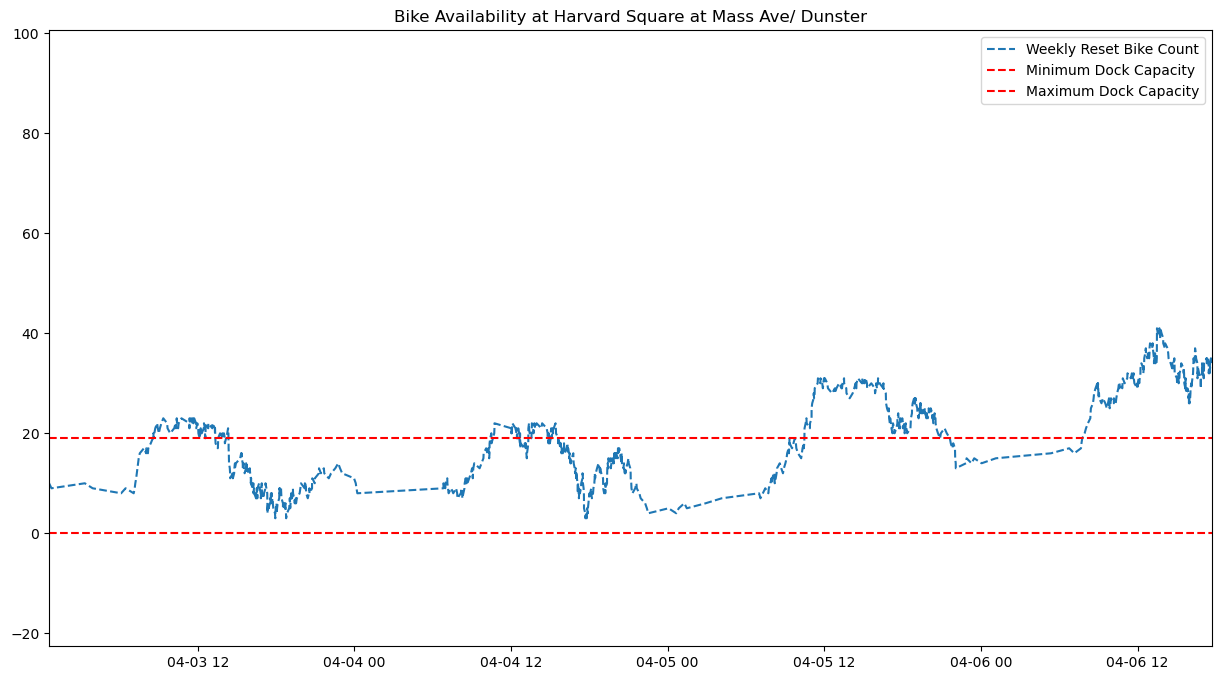

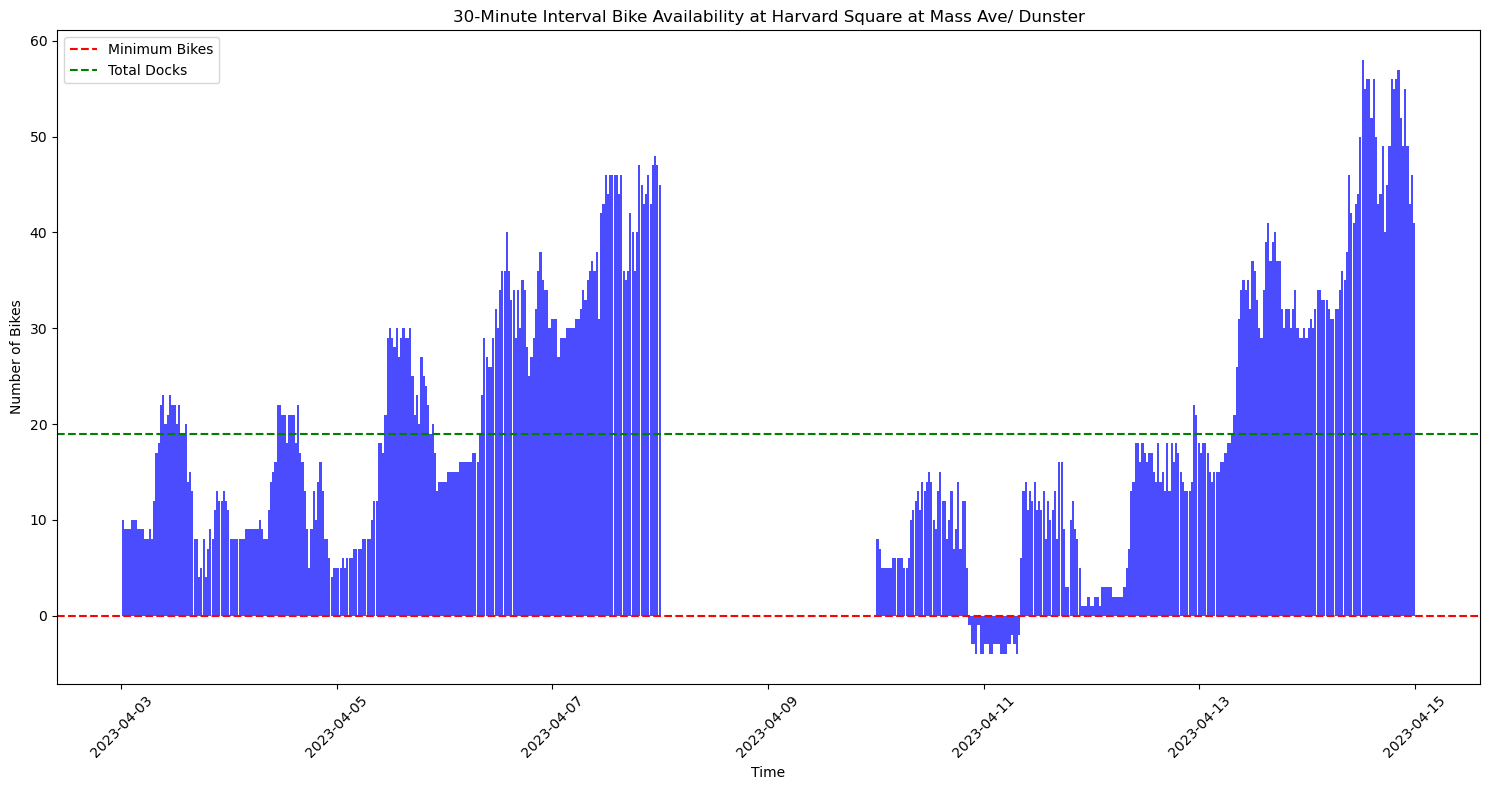

,time,bikes
0,2023-04-03 00:20:19,10
1,2023-04-03 00:50:19,9
2,2023-04-03 01:20:19,9
3,2023-04-03 01:50:19,9
4,2023-04-03 02:20:19,10
...,...,...
475,2023-04-14 21:50:19,55
476,2023-04-14 22:20:19,49
477,2023-04-14 22:50:19,43
478,2023-04-14 23:20:19,46


In [12]:
data = weekdays(228)
fig, ax = plt.subplots(figsize=(15, 8))
# plt.plot(data['time'], data['num_bikes'], label='Cumulative Bike Count')
plt.plot(data['time'].values, data['num_bikes_weekly'].values, label='Weekly Reset Bike Count', linestyle='--')
ax.axhline(y=0, color='red', linestyle='--', label='Minimum Dock Capacity')
ax.axhline(y=stations['Total Docks'][228], color='red', linestyle='--', label='Maximum Dock Capacity')
plt.xlim(data.time[0], data.time[1000])
plt.title(f'Bike Availability at {stations.NAME[228]}')
plt.legend()
plt.show()

bikes_intervals(228, pstart=0, pend=5000, reset_weekly=True)

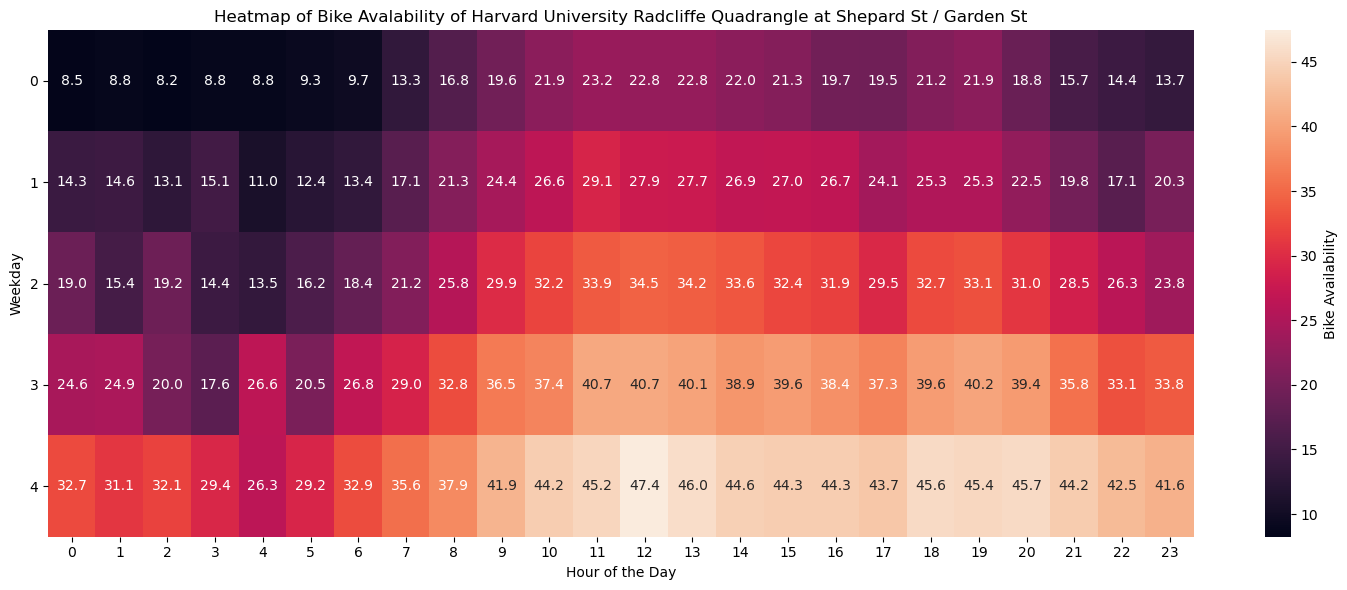

In [13]:
# sketch the heatmap of average hourly bikes of a station during weekdays
def station_heatmap(data):
    data['hour'] = data.time.dt.hour
    
    pattern = data.groupby(['weekday', 'hour']).agg({'num_bikes_weekly': 'mean'}) # returns the average number of bikes in a station during a specific hour of a week with weekly rebalancing

    heatmap_data = pattern.pivot_table(index="weekday", columns="hour", values="num_bikes_weekly", fill_value=0)

    # Step 2: Plot the heatmap
    plt.figure(figsize=(15, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cbar_kws={'label': 'Bike Availability'})

    # Step 3: Customize the plot
    plt.title(f"Heatmap of Bike Avalability of {data.start_station_name[0]}")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Weekday")
    plt.yticks(rotation=0)  # Keep weekday labels horizontal

    # Show the heatmap
    plt.tight_layout()
    plt.show()

# for i in range(len(origins)-400):
#     station_heatmap(i)
station_heatmap(weekdays(228))

In [14]:
# record the average hourly bike availability of each week in a 3d matrix for rach station

def station_3d_matrix(data, plotting = False):
    # Add the 'week' column for grouping by week number
    data['week'] = data['time'].dt.isocalendar().week
    data['year'] = data['time'].dt.year  # To handle weeks across multiple years
    max_weekday = 4  # Weekdays (0 to 4)
    max_hour = 23
    heatmap_list = []
    # Group by year and week
    weekly_groups = data.groupby(['year', 'week'])

    for (year, week), week_data in weekly_groups:
        # Extract the week-specific data
        week_data = week_data.copy()
        week_data['hour'] = week_data['time'].dt.hour

        # Aggregate the data for the heatmap
        pattern = week_data.groupby(['weekday', 'hour']).agg({'num_bikes_weekly': 'mean'})

        # Create the pivot table
        heatmap_data = pattern.pivot_table(index="weekday", columns="hour", values="num_bikes_weekly")

        # Reindex to ensure a 5x24 matrix for weekdays (0-4) and hours (0-23)
        heatmap_data = heatmap_data.reindex(index=range(5), columns=range(24))  # Ensures 5 weekdays and 24 hours

        # Interpolate missing data along both axes (linear interpolation)
        heatmap_data = heatmap_data.interpolate(method='linear', axis=1)  # Interpolate along hours
        heatmap_data = heatmap_data.interpolate(method='linear', axis=0)  # Interpolate along weekdays

        # Handle wraparound from hour 23 to 0 correctly (previous day's hour 23 for the first hour of the next day)
        for weekday in range(5):
            if pd.isna(heatmap_data.at[weekday, 0]):
                heatmap_data.at[weekday, 0] = heatmap_data.at[(weekday - 1) % 5, 23]

        # Check if still any NaN values exist, fill them with nearest values
        heatmap_data = heatmap_data.fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)
        heatmap_data = heatmap_data.fillna(method='bfill', axis=0).fillna(method='ffill', axis=0)

        # Ensure the final heatmap is always a 5x24 matrix
        assert heatmap_data.shape == (5, 24), f"Expected 5x24 matrix, but got {heatmap_data.shape}"

        if plotting:
        # Plot the heatmap
            plt.figure(figsize=(15, 6))
            sns.heatmap(heatmap_data, annot=True, fmt=".0f", cbar_kws={'label': 'Bike Availability'})

            # Customize the plot
            plt.title(f"Heatmap of Bike Availability: Week {week}, {year}")
            plt.xlabel("Hour of the Day")
            plt.ylabel("Weekday")
            plt.yticks(rotation=0)  # Keep weekday labels horizontal

            # Show the heatmap
            plt.tight_layout()
            plt.show()
        
        heatmap_array = np.zeros((max_weekday + 1, max_hour + 1))  # 5x24
        for weekday, hour_data in heatmap_data.iterrows():
            for hour, value in hour_data.items():
                heatmap_array[int(weekday), int(hour)] = value

        # Append the 2D heatmap to the list
        heatmap_list.append(heatmap_array)

    # Stack all 2D heatmaps into a 3D matrix (weeks x weekdays x hours)
    heatmap_3d_matrix = np.stack(heatmap_list, axis=0)

    return heatmap_3d_matrix, data.time.iloc[0], data.time.iloc[-1]

# Example usage
heatmap_matrix, start, end = station_3d_matrix(weekdays(4))
print(start, end)
print(f"Station: {stations.NAME[4]}")
print(f"3D Heatmap Matrix Shape: {heatmap_matrix.shape}")
print(f"Weekly Heatmap (First Week): \n{heatmap_matrix[0]}")
heatmap_matrix.shape

station_3d_matrix(weekdays(4))

2023-04-13 15:23:17 2024-10-31 08:40:13.465000
Station: 2 Hummingbird Lane at Olmsted Green
3D Heatmap Matrix Shape: (70, 5, 24)
Weekly Heatmap (First Week): 
[[6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 6. 6. 6. 6. 6. 6. 6.]]


(array([[[6. , 6. , 6. , ..., 6. , 6. , 6. ],
         [7. , 7. , 7. , ..., 7. , 7. , 7. ],
         [7. , 7. , 7. , ..., 7. , 7. , 7. ],
         [7. , 7. , 7. , ..., 7. , 7. , 7. ],
         [7. , 7. , 7. , ..., 6. , 6. , 6. ]],
 
        [[8. , 9. , 9. , ..., 9. , 9. , 9. ],
         [9. , 8. , 8. , ..., 8. , 8. , 8. ],
         [8. , 8. , 8. , ..., 8. , 8. , 8. ],
         [8. , 8. , 8. , ..., 8. , 8. , 8. ],
         [8. , 8. , 8. , ..., 8. , 8. , 8. ]],
 
        [[7. , 7. , 7. , ..., 7. , 7. , 7. ],
         [7. , 7. , 7. , ..., 7. , 7. , 7. ],
         [7. , 7. , 7. , ..., 7. , 7. , 7. ],
         [7. , 7. , 7. , ..., 7. , 7. , 7. ],
         [7. , 7. , 7. , ..., 7. , 7. , 7. ]],
 
        ...,
 
        [[8. , 8. , 8. , ..., 8. , 8. , 8. ],
         [7. , 7. , 7. , ..., 7. , 7. , 7. ],
         [7. , 7. , 7. , ..., 7. , 7. , 7. ],
         [7. , 7. , 7. , ..., 7. , 7. , 7. ],
         [7. , 7. , 7. , ..., 8. , 8. , 8. ]],
 
        [[9. , 9. , 9. , ..., 9. , 9. , 9. ],
       

# Weather Data

In [15]:
# Prepare weather dataset

def cleaning(data):
    # Convert 'DATE' column to datetime
    data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')

    # Extract the hour from the 'DATE' column
    data['hour'] = data['DATE'].dt.hour
    data['date'] = data['DATE'].dt.date

    # Aggregate by hour and calculate the mean for temperature, wind_speed, and precipitation
    weather = data.groupby(['date', 'hour']).agg({
        'temperature': 'mean',
        'wind_speed': 'mean',
        'precipitation': 'mean'
    }).reset_index()

    return pd.DataFrame(weather)

weather = pd.concat([cleaning(pd.read_csv('Hourly2023.csv')), cleaning(pd.read_csv('Hourly2024.csv'))], ignore_index=True)
weather

/tmp/ipykernel_18648/4252785299.py:20: DtypeWarning: Columns (32,56,62,72,73,75,77,78,79,81,83,96,97,99,101,114,115,117,119) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.concat([cleaning(pd.read_csv('Hourly2023.csv')), cleaning(pd.read_csv('Hourly2024.csv'))], ignore_index=True)


,date,hour,temperature,wind_speed,precipitation
0,2023-01-01,0,11.300000,3.266667,0.25
1,2023-01-01,1,11.400000,3.600000,0.35
2,2023-01-01,2,11.100000,3.100000,1.80
3,2023-01-01,3,11.066667,3.100000,2.30
4,2023-01-01,4,12.200000,4.350000,1.10
...,...,...,...,...,...
16795,2024-12-01,19,NaN,NaN,NaN
16796,2024-12-01,20,NaN,NaN,NaN
16797,2024-12-01,21,NaN,NaN,NaN
16798,2024-12-01,22,NaN,NaN,NaN


In [16]:
station_matrix, start, end = station_3d_matrix(weekdays(4))
start_date = start.to_pydatetime().date()
start_hour = start.hour
end_date = end.to_pydatetime().date()
end_hour = end.hour

filtered_weather = weather[
    ((weather['date'] >= start_date) &
    (weather['date'] <= end_date))
]
filtered_weather.reset_index(drop=True)

,date,hour,temperature,wind_speed,precipitation
0,2023-04-13,0,18.85,2.85,0.0
1,2023-04-13,1,12.80,4.10,0.0
2,2023-04-13,2,13.30,0.75,0.0
3,2023-04-13,3,12.75,1.80,0.0
4,2023-04-13,4,11.70,3.10,0.0
...,...,...,...,...,...
13603,2024-10-31,19,76.60,8.90,0.0
13604,2024-10-31,20,75.10,9.20,0.0
13605,2024-10-31,21,71.70,9.70,0.0
13606,2024-10-31,22,68.10,11.30,0.0


In [17]:
# Create 3D matrix for temperature
def weather_3d_matrix(data, variable='temperature', plotting=False):
    # Ensure a copy of the DataFrame is used to avoid SettingWithCopyWarning
    data = data.copy()
    
    # Convert 'date' column to datetime
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    
    # Add 'weekday' column
    data['weekday'] = data['date'].dt.weekday
    
    # Filter to keep only weekdays and reset the index
    data = data[data['weekday'].isin(range(5))].reset_index(drop=True)
    
    # Add 'week' and 'year' columns for grouping
    data['week'] = data['date'].dt.isocalendar().week
    data['year'] = data['date'].dt.year
    
    # Interpolate missing values in the variable column
    data[variable] = data[variable].interpolate()
    
    max_weekday = 4  # Weekdays (0 to 4)
    max_hour = 23
    heatmap_list = []
    
    # Group by year and week
    weekly_groups = data.groupby(['year', 'week'])

    for (year, week), week_data in weekly_groups:
        week_data = week_data.copy()

        # Aggregate and pivot to create the heatmap
        pattern = week_data.groupby(['weekday', 'hour']).agg({variable: 'mean'})
        heatmap_data = pattern.pivot_table(index="weekday", columns="hour", values=variable)
        
        # Fill any remaining NaN values in the heatmap with interpolation across the grid
        heatmap_data = heatmap_data.apply(lambda x: x.interpolate(method='linear', axis=0), axis=1).fillna(method='bfill').fillna(method='ffill')
        
        if plotting:
            # Plot the heatmap
            plt.figure(figsize=(15, 6))
            sns.heatmap(heatmap_data, annot=True, fmt=".0f", cbar_kws={'label': f'{variable}'})
            plt.title(f"Heatmap of {variable}: Week {week}, {year}")
            plt.xlabel("Hour of the Day")
            plt.ylabel("Weekday")
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
        
        heatmap_array = np.zeros((max_weekday + 1, max_hour + 1))
        for weekday, hour_data in heatmap_data.iterrows():
            for hour, value in hour_data.items():
                heatmap_array[int(weekday), int(hour)] = value
        
        heatmap_list.append(heatmap_array)
    
    heatmap_3d_matrix = np.stack(heatmap_list, axis=0)
    return heatmap_3d_matrix

# Example of usage:
temperature_matrix = weather_3d_matrix(filtered_weather, variable='temperature')
wind_matrix = weather_3d_matrix(filtered_weather, variable='wind_speed')
precipitation_matrix = weather_3d_matrix(filtered_weather, variable='precipitation')
wind_matrix.shape


(82, 5, 24)

In [18]:


# Reshape matrices for ease of handling
num_weeks, num_days, num_hours = station_matrix.shape
start_week = start_date.isocalendar()[1]
start_weekday = start_date.isocalendar()[2]-1
features = []

# Flatten and combine features
for week in range(num_weeks):
    for day in range(num_days):
        for hour in range(num_hours):
            features.append([
                (week+start_week) % 52,  # Week of the year
                (day+start_weekday)%5,        # Day of the week
                (hour+start_hour)%24,       # Hour of the day
                temperature_matrix[week, day, hour],
                wind_matrix[week, day, hour],
                precipitation_matrix[week, day, hour],
            ])

features = np.array(features)
targets = station_matrix.flatten()

# Normalize data
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
targets = targets.reshape(-1, 1)
targets = scaler.fit_transform(targets)

# Reshape for sequential model
sequence_length = 24  # Using the last 24 hours to predict the next value
X, y = [], []

for i in range(len(features) - sequence_length):
    X.append(features[i:i+sequence_length])
    y.append(targets[i+sequence_length])

X = np.array(X)
y = np.array(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(sequence_length, X.shape[2])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test)


Epoch 1/20
210/210 [==============================] - 4s 13ms/step - loss: 0.0381 - mae: 0.1516 - val_loss: 0.0322 - val_mae: 0.1416
Epoch 2/20
210/210 [==============================] - 2s 11ms/step - loss: 0.0310 - mae: 0.1381 - val_loss: 0.0292 - val_mae: 0.1332
Epoch 3/20
210/210 [==============================] - 2s 11ms/step - loss: 0.0291 - mae: 0.1333 - val_loss: 0.0293 - val_mae: 0.1327
Epoch 4/20
210/210 [==============================] - 2s 11ms/step - loss: 0.0281 - mae: 0.1309 - val_loss: 0.0289 - val_mae: 0.1372
Epoch 5/20
210/210 [==============================] - 2s 12ms/step - loss: 0.0271 - mae: 0.1287 - val_loss: 0.0256 - val_mae: 0.1249
Epoch 6/20
210/210 [==============================] - 3s 12ms/step - loss: 0.0260 - mae: 0.1258 - val_loss: 0.0256 - val_mae: 0.1280
Epoch 7/20
210/210 [==============================] - 2s 11ms/step - loss: 0.0247 - mae: 0.1224 - val_loss: 0.0232 - val_mae: 0.1206
Epoch 8/20
210/210 [==============================] - 2s 11ms/step - 

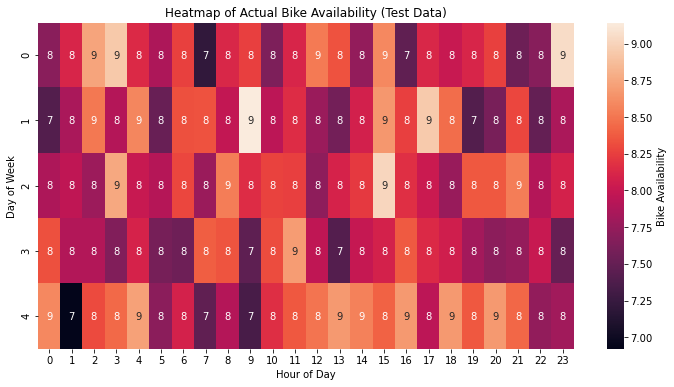

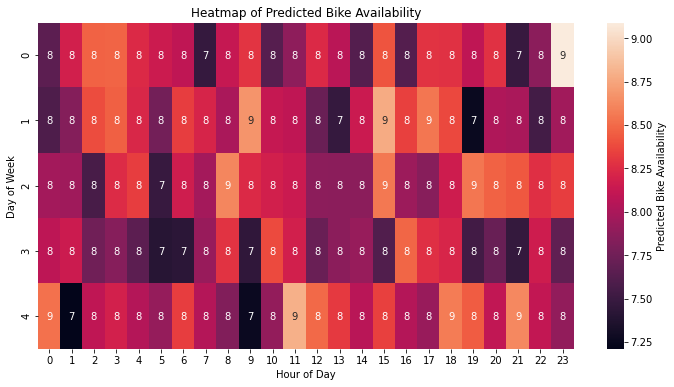

In [13]:
# Reshape test data and predictions for heatmap comparison
# Determine the number of weeks in the test set
num_weeks_test = y_test_original.shape[0] // (num_days * num_hours)

y_test_reshaped = y_test_original[:num_weeks_test * num_days * num_hours].reshape(num_weeks_test, num_days, num_hours)
predictions_reshaped = predictions[:num_weeks_test * num_days * num_hours].reshape(num_weeks_test, num_days, num_hours)

# Generate heatmap for actual data
plt.figure(figsize=(12, 6))
sns.heatmap(np.mean(y_test_reshaped, axis=0), annot=True, fmt=".0f", cbar_kws={'label': 'Bike Availability'})
plt.title('Heatmap of Actual Bike Availability (Test Data)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

# Generate heatmap for predicted data
plt.figure(figsize=(12, 6))
sns.heatmap(np.mean(predictions_reshaped, axis=0), annot=True, fmt=".0f", cbar_kws={'label': 'Predicted Bike Availability'})
plt.title('Heatmap of Predicted Bike Availability')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


In [14]:
# Reshape test data and predictions for heatmap comparison
num_weeks_test = y_test_original.shape[0] // (num_days * num_hours)

y_test_reshaped = y_test_original[:num_weeks_test * num_days * num_hours].reshape(num_weeks_test, num_days, num_hours)
predictions_reshaped = predictions[:num_weeks_test * num_days * num_hours].reshape(num_weeks_test, num_days, num_hours)

# Compute average across weeks for both actual and predicted data
actual_mean_per_hour = np.mean(y_test_reshaped, axis=0)
predicted_mean_per_hour = np.mean(predictions_reshaped, axis=0)

# Flatten the averaged data to calculate RMSE between heatmaps
actual_flattened = actual_mean_per_hour.flatten()
predicted_flattened = predicted_mean_per_hour.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_flattened, predicted_flattened))
print(f"RMSE between heatmaps: {rmse}")


RMSE between heatmaps: 0.2604898963334749


# Move all the prediction steps into a function to predict for all stations

In [19]:
def predict_station_demand(n, plotting=False):
    station_matrix, start, end = station_3d_matrix(weekdays(n))
    start_date = start.to_pydatetime().date()
    start_hour = start.hour
    end_date = end.to_pydatetime().date()
    end_hour = end.hour

    filtered_weather = weather[
        ((weather['date'] >= start_date) &
        (weather['date'] <= end_date))
    ]
    filtered_weather.reset_index(drop=True)

    temperature_matrix = weather_3d_matrix(filtered_weather, variable = 'temperature')
    wind_matrix = weather_3d_matrix(filtered_weather, variable = 'wind_speed')
    precipitation_matrix = weather_3d_matrix(filtered_weather, variable = 'precipitation')
    

    # Reshape matrices for ease of handling
    num_weeks, num_days, num_hours = station_matrix.shape
    start_week = start_date.isocalendar()[1]
    start_weekday = start_date.isocalendar()[2]-1
    features = []

    # Flatten and combine features
    for week in range(num_weeks):
        for day in range(num_days):
            for hour in range(num_hours):
                features.append([
                    (week+start_week) % 52,  # Week of the year
                    (day+start_weekday)%5,        # Day of the week
                    (hour+start_hour)%24,       # Hour of the day
                    temperature_matrix[week, day, hour],
                    wind_matrix[week, day, hour],
                    precipitation_matrix[week, day, hour],
                ])

    features = np.array(features)
    targets = station_matrix.flatten()

    # Normalize data
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    targets = targets.reshape(-1, 1)
    targets = scaler.fit_transform(targets)

    # Reshape for sequential model
    sequence_length = 24  # Using the last 24 hours to predict the next value
    X, y = [], []

    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(targets[i+sequence_length])

    X = np.array(X)
    y = np.array(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    # Build the LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation='relu', input_shape=(sequence_length, X.shape[2])),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    loss, mae = model.evaluate(X_test, y_test)
#     print(f"Test Loss: {loss}, Test MAE: {mae}")

    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform predictions to original scale
    predictions = scaler.inverse_transform(predictions)
    y_test_original = scaler.inverse_transform(y_test)
    num_weeks_test = y_test_original.shape[0] // (num_days * num_hours)

    y_test_reshaped = y_test_original[:num_weeks_test * num_days * num_hours].reshape(num_weeks_test, num_days, num_hours)
    predictions_reshaped = predictions[:num_weeks_test * num_days * num_hours].reshape(num_weeks_test, num_days, num_hours)
    if plotting:
        # Generate heatmap for actual data
        plt.figure(figsize=(12, 6))
        sns.heatmap(np.mean(y_test_reshaped, axis=0), annot=True, fmt=".0f", cbar_kws={'label': f'Bike Availability'})
        plt.title(f'Heatmap of Actual Bike Availability  @ {stations.NAME[n]}')
        plt.xlabel('Hour of Day')
        plt.ylabel('Day of Week')
        plt.show()

        # Generate heatmap for predicted data
        plt.figure(figsize=(12, 6))
        sns.heatmap(np.mean(predictions_reshaped, axis=0), annot=True, fmt=".0f", cbar_kws={'label': 'Predicted Bike Availability'})
        plt.title(f'Heatmap of Predicted Bike Availability @ {stations.NAME[n]}')
        plt.xlabel('Hour of Day')
        plt.ylabel('Day of Week')
        plt.show()


    # Flatten the averaged data to calculate RMSE between heatmaps
    actual_flattened = y_test_reshaped.flatten()
    predicted_flattened = predictions_reshaped.flatten()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_flattened, predicted_flattened))
    print(n)
    return (rmse, y_test_reshaped, predictions_reshaped)

# predict_station_demand(228, plotting=True)

In [24]:
from multiprocessing import Pool

if __name__ == '__main__':
    with Pool(processes=25) as pool:  # Adjust the number of processes as needed
        results = pool.map(predict_station_demand, range(len(stations)))

KeyboardInterrupt: 

In [ ]:
np.save('restlts.npy', np.array(results))

In [40]:
errors = list(pd.read_csv('PartialRMSE.csv', index_col=0)['RMSE'])
test_matrices = np.load('partial_predict.npy')
prediction_matrices = np.load('partial_predict.npy')

In [ ]:
for n in range(len(errors), len(stations)):
    if n%15==0:
        print(n)
    err, test, pred = predict_station_demand(n)
    errors.append(err)
    list(test_matrices).append(test)
    list(prediction_matrices).append(pred)
    df = pd.DataFrame({'station':stations.NAME[:len(errors)], 'RMSE':errors})
    df.to_csv('PartialRMSE.csv')
    np.save('partial_predict.npy', np.array(prediction_matrices))
    np.save('partial_test.npy', np.array(test_matrices))

df = pd.DataFrame({'station':stations.NAME[:len(errors)], 'RMSE':errors})
df.to_csv('FinalRMSE.csv')
np.save('final_test.npy', np.array(test_matrices))
np.save('final_predict.npy', np.array(prediction_matrices))

40/40 [==============================] - 0s 2ms/step
266
40/40 [==============================] - 0s 2ms/step
267
40/40 [==============================] - 0s 2ms/step
268
40/40 [==============================] - 0s 2ms/step
269
270
40/40 [==============================] - 0s 2ms/step
270
40/40 [==============================] - 0s 2ms/step
271
40/40 [==============================] - 0s 2ms/step
272
40/40 [==============================] - 0s 2ms/step
273
40/40 [==============================] - 0s 2ms/step
274
40/40 [==============================] - 0s 2ms/step
275
40/40 [==============================] - 0s 2ms/step
276
40/40 [==============================] - 0s 2ms/step
277
40/40 [==============================] - 0s 2ms/step
278
40/40 [==============================] - 0s 2ms/step
279
40/40 [==============================] - 0s 2ms/step
280
40/40 [==============================] - 0s 2ms/step
281
40/40 [==============================] - 0s 2ms/step
282
40/40 [====================

In [36]:
df = pd.DataFrame({'station':stations.NAME[:len(errors)], 'RMSE':errors})
errors.to_csv('PartialRMSE.csv')

In [24]:
len(prediction_matrices)

262

In [6]:
test_matrices = np.load('final_test.npy')
prediction_matrices = np.load('final_predict.npy')
display(test_matrices[1][0])
display(prediction_matrices[1][0])

array([[ 6.7387257,  7.5989766, 10.2334   ,  7.9541326,  9.822234 ,
         7.381075 ,  7.6740932, 10.204099 ,  6.5028057,  7.445646 ,
         8.664649 ,  6.972875 ,  8.193141 ,  7.376812 ,  7.5116053,
        10.365867 ,  7.124045 ,  7.3748717,  8.7278185,  7.189818 ,
         8.835233 ,  7.455429 ,  6.520262 ,  6.65434  ],
       [ 7.4050226,  6.8306603,  7.478742 ,  7.728175 ,  8.517214 ,
         6.853572 ,  8.391122 ,  8.339158 ,  7.4617906,  7.592238 ,
         8.766565 ,  8.624045 ,  6.216678 ,  7.906411 ,  8.306326 ,
         8.696724 ,  8.353646 ,  9.910942 , 11.03659  ,  9.068428 ,
         8.030856 ,  7.371227 ,  6.1325154,  8.459335 ],
       [ 7.6055646,  7.993575 ,  7.852638 ,  7.8735714, 10.393625 ,
         7.3922157, 10.632449 , 10.696121 ,  7.7726355,  8.009619 ,
         7.6287932,  8.080081 ,  7.469975 ,  8.434399 ,  9.408213 ,
         8.850941 ,  7.907703 ,  7.6574225,  6.8398633,  9.582392 ,
         7.914389 ,  8.692416 , 10.5588255,  8.069532 ],
       [ 9.68

array([[ 6.7387257,  7.5989766, 10.2334   ,  7.9541326,  9.822234 ,
         7.381075 ,  7.6740932, 10.204099 ,  6.5028057,  7.445646 ,
         8.664649 ,  6.972875 ,  8.193141 ,  7.376812 ,  7.5116053,
        10.365867 ,  7.124045 ,  7.3748717,  8.7278185,  7.189818 ,
         8.835233 ,  7.455429 ,  6.520262 ,  6.65434  ],
       [ 7.4050226,  6.8306603,  7.478742 ,  7.728175 ,  8.517214 ,
         6.853572 ,  8.391122 ,  8.339158 ,  7.4617906,  7.592238 ,
         8.766565 ,  8.624045 ,  6.216678 ,  7.906411 ,  8.306326 ,
         8.696724 ,  8.353646 ,  9.910942 , 11.03659  ,  9.068428 ,
         8.030856 ,  7.371227 ,  6.1325154,  8.459335 ],
       [ 7.6055646,  7.993575 ,  7.852638 ,  7.8735714, 10.393625 ,
         7.3922157, 10.632449 , 10.696121 ,  7.7726355,  8.009619 ,
         7.6287932,  8.080081 ,  7.469975 ,  8.434399 ,  9.408213 ,
         8.850941 ,  7.907703 ,  7.6574225,  6.8398633,  9.582392 ,
         7.914389 ,  8.692416 , 10.5588255,  8.069532 ],
       [ 9.68